In [15]:
from BMI_HBVmountain_Python import *
from Calibration import *

## Load forcing data

In [20]:
# forcing = read_csv("Refactoring/Forcing/forcingWark.csv"); #Example dataset, observation data

# for i in range(len(forcing)):
#     forcing['DATE'][i] = datetime.datetime.strptime(forcing['DATE'][i], '%Y-%m-%d')
#     forcing['DATE'][i] = forcing['DATE'][i].date()
# forcing.set_index('DATE', inplace=True)

forcing = pd.read_csv('Data/BigCreek/forcing_bigrockcreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['Date'][i] = forcing['Date'][i].date()
forcing.set_index('Date', inplace=True)
forcing.loc[forcing['prec_era5'] > 500, 'prec_era5'] = 0

C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Setting up the model

In [14]:
index = forcing.index.values
streamflow = forcing.streamflow.values

df = pd.DataFrame({'time': index, 'streamflow': streamflow})
df.set_index('time', inplace=True)
df
df.to_csv('Data/BigCreek/Discharge_BigRockCreek.csv')

In [23]:
model = BMI_HBVmountain()

In [24]:
config_file = model.setup()

In [25]:
model.initialize(config_file)

### Parameters

In [26]:
bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection()
model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', forest_parameters)
model.set_value('grass_parameters', grass_parameters)
model.set_value('rip_parameters', rip_parameters)
model.set_value('slow_parameters', slow_parameters)

In [27]:
param_list = parameter_conversion('output', nsmallest=16)

model.set_value('bare_parameters', param_list[0][0])
model.set_value('forest_parameters', param_list[0][1])
model.set_value('grass_parameters', param_list[0][2])
model.set_value('rip_parameters', param_list[0][3])
model.set_value('slow_parameters', param_list[0][4])

### Forcings

In [28]:
model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings

In [29]:
model.set_value('Elevation', Main.Elevations(50, 200, 450, 280, 280))

model.set_value('Glacier', [0.0, 0.0, 0.0, 0.0])
model.set_value('Sunhours', [8.83, 10.26, 11.95, 13.75, 15.28, 16.11, 15.75, 14.36, 12.63, 10.9, 9.28, 8.43])
model.set_value('bare_input', Main.HRU_Input([0,0,0,0], 0, np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('forest_input', Main.HRU_Input([0.8,0.1,0.1,0.0], 0.4,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('grass_input', Main.HRU_Input([0.3,0.3,0.2,0.2], 0.3,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('rip_input', Main.HRU_Input([0.0,0.1,0.3,0.6], 0.3,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.2,0.2,0.3,0.3])
model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [30]:
Discharge = []
timestamp = []
ETP = []
while (model.get_value_ptr('Current_Date') < (model.get_value_ptr('Date')[-1])):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))
    ETP.append(model.get_value_ptr('Total_Evaporation'))

## Analysis

In [31]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.000000,0.317567
1986-01-03,0.000000,0.305913
1986-01-04,0.000000,0.301543
1986-01-05,0.000635,0.308826
1986-01-06,0.002411,0.367095
...,...,...
2005-12-27,0.052122,0.301543
2005-12-28,0.051354,0.301543
2005-12-29,0.050593,0.301543
2005-12-30,0.049845,0.301543


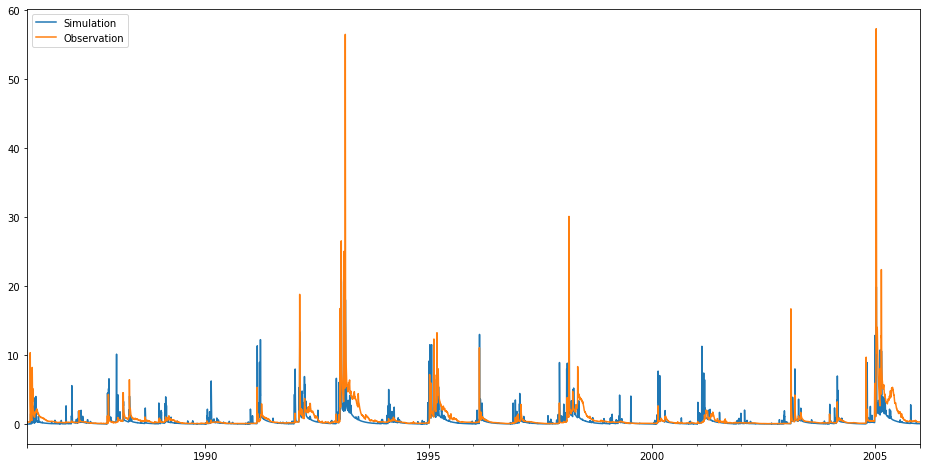

In [32]:
plt.figure(figsize=[16,8])
combined_discharge.simulation.plot(label='Simulation')
combined_discharge.streamflow.plot(label='Observation')
plt.legend();

## Clean up

In [21]:
model.finalize()

In [33]:
print(model)

In [33]:
sim, streamflow, prec, ETP = combined_discharge.simulation.sum(), forcing.streamflow.sum(), forcing.prec_era5.sum(), np.sum(ETP)

In [44]:
streamflow - sim + prec - streamflow - ETP

13.868311746967265

Text(0, 0.5, 'mm day-1')

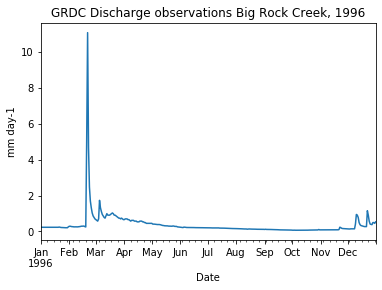

In [27]:
forcing.index = pd.to_datetime(forcing.index)
forcing.streamflow.loc[forcing.index.year == 1996].plot()
plt.title('GRDC Discharge observations Big Rock Creek, 1996')
plt.ylabel('mm day-1')